# 🌎📡 Satellite images classification using Vision Transformer

***

## 📁 Set up the environment

#### Installing dependencies

In [1]:
!pip install -q wandb
!pip install -q datasets transformers

     |████████████████████████████████| 1.9 MB 8.0 MB/s 
     |████████████████████████████████| 168 kB 69.7 MB/s 
     |████████████████████████████████| 182 kB 41.1 MB/s 
     |████████████████████████████████| 62 kB 796 kB/s 
     |████████████████████████████████| 168 kB 69.6 MB/s 
     |████████████████████████████████| 166 kB 67.2 MB/s 
     |████████████████████████████████| 166 kB 54.9 MB/s 
     |████████████████████████████████| 162 kB 35.8 MB/s 
     |████████████████████████████████| 162 kB 63.1 MB/s 
     |████████████████████████████████| 158 kB 65.4 MB/s 
     |████████████████████████████████| 157 kB 79.4 MB/s 
     |████████████████████████████████| 157 kB 55.4 MB/s 
     |████████████████████████████████| 157 kB 90.9 MB/s 
     |████████████████████████████████| 157 kB 58.5 MB/s 
     |████████████████████████████████| 157 kB 63.7 MB/s 
     |████████████████████████████████| 157 kB 83.2 MB/s 
     |████████████████████████████████| 157 kB 54.0 MB/s 
     |███████████

In [5]:
!pip install -q plotly-express

In [ ]:
!pip install -U gdown -q

#### Importing libraries and logging

In [2]:
from huggingface_hub import notebook_login


notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [222]:
import wandb


wandb.login()
wandb.init(project="vit-classification-eurosat", entity="polejowska")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [61]:
from datasets import load_dataset, load_metric
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor,
)
import numpy as np
from tqdm import tqdm

from PIL import Image
import requests

import zipfile
from io import BytesIO
import gdown
import tensorflow as tf
from tensorflow import keras

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## 📚 Loading the dataset



In [7]:
dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-71c8f80171b09b95/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## 🔍 Explore the dataset

In [8]:
print(f"Dataset structure: {dataset}\n")
print(f"Number of training examples: {len(dataset['train'])}\n")
print(f"Dataset sample (image, label): {dataset['train'][0]}\n")
print(f"Dataset features: {dataset['train'].features}\n")
print(f"Class labels: {dataset['train'].features['label'].names}\n")

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

Number of training examples: 27000

Dataset sample (image, label): {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F6EA3A9AF40>, 'label': 0}

Dataset features: {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

Class labels: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']



In [9]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [10]:
wandb.config.update({"class_labels": dataset["train"].features["label"].names})
wandb.config.update({"num_train_examples": len(dataset["train"])})

#### 🗺️ Visualize data and display essentail information

In [119]:
def plot_class_distribution(dataset, id2label, dataset_name="dataset"):
    fig = px.histogram(
        x=[id2label[label] for label in dataset["label"]],
        title=f"Distribution of classes in the {dataset_name}",
    )
    fig.update_layout(xaxis_title="Class", yaxis_title="Number of examples")
    fig.show()
    return fig

enitre_dataset_fig = plot_class_distribution(dataset["train"], id2label)
wandb.log({"class distribution in the entire dataset": enitre_dataset_fig})

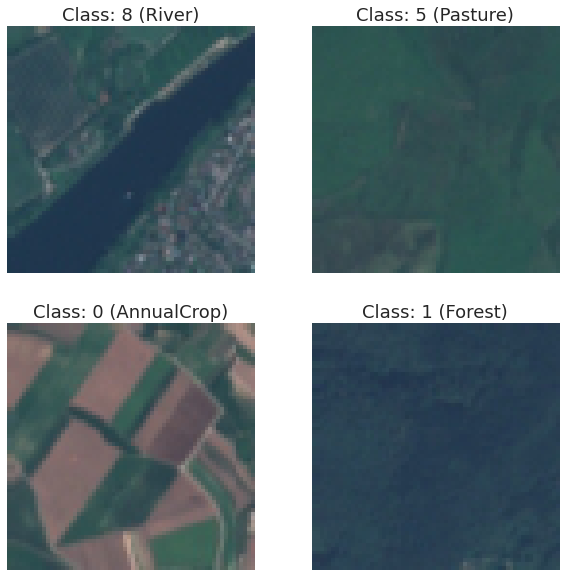

In [164]:
def display_random_images(dataset, label2id, id2label):
    # display four random images from the dataset using plotly
    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        random_image = np.random.randint(0, len(dataset))
        image = dataset[random_image]["image"]
        label = dataset[random_image]["label"]
        class_name = id2label[label]

        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(image)
        ax.set_title(f"Class: {label} ({class_name})")
        ax.axis("off")
    plt.show()

    wandb.log({"random_images": fig})


display_random_images(dataset["train"], label2id, id2label)

***
## 🔨 Data processing

1. Resize images
2. Normalize RGB channels using mean and standard deviation

In [223]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
# model_checkpoint = "facebook/convnext-tiny-224"
# model_checkpoint = "google/vit-base-patch16-224-in21k"

In [224]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/preprocessor_config.json
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [225]:
resize_value = (feature_extractor.size['height'], feature_extractor.size['width'])
# resize_value = (feature_extractor.size['shortest_edge'], feature_extractor.size['shortest_edge'])

In [226]:
print(f"Resize value: {resize_value}")

Resize value: (224, 224)


In [227]:
data_transforms = Compose(
        [
            Resize(resize_value),
            ToTensor(),
            Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ]
    )

In [194]:
def add_pixel_values_feature(batch):
  batch["pixel_values"] = [
        data_transforms(image.convert("RGB")) for image in batch["image"]
  ]
  return batch

In [127]:
split = dataset["train"].train_test_split(test_size=0.2)
train_dataset = split["train"]
validation_dataset_split = split["test"].train_test_split(test_size=0.3)
validation_dataset = validation_dataset_split["train"]
test_dataset = validation_dataset_split["test"]
train_dataset = train_dataset.select(range(0, len(train_dataset), 5))
validation_dataset = validation_dataset.select(range(0, len(validation_dataset), 5))
test_dataset = test_dataset.select(range(0, len(test_dataset), 5))
print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(validation_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

Length of training dataset: 4320
Length of validation dataset: 756
Length of test dataset: 324


In [128]:
train_dataset_fig = plot_class_distribution(train_dataset, id2label, dataset_name="training dataset")
wandb.log({"class distribution in the training dataset": train_dataset_fig})

validation_dataset_fig = plot_class_distribution(validation_dataset, id2label, dataset_name="validation dataset")
wandb.log({"class distribution in the validation dataset": validation_dataset_fig})

test_dataset_fig = plot_class_distribution(test_dataset, id2label, dataset_name="test dataset")
wandb.log({"class distribution in the test dataset": test_dataset_fig})

In [129]:
wandb.config.update({"num_train_examples": len(train_dataset)})
wandb.config.update({"num_validation_examples": len(validation_dataset)})
wandb.config.update({"num_test_examples": len(test_dataset)})

In [130]:
train_dataset.set_transform(add_pixel_values_feature)
validation_dataset.set_transform(add_pixel_values_feature)
test_dataset.set_transform(add_pixel_values_feature)

#### W&B - log dataset tables

In [131]:
def create_table(dataset):
    table = wandb.Table(columns=["image", "label", "class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(wandb.Image(image), label, id2label[label])

    return table

In [132]:
train_table = create_table(train_dataset)
validation_table = create_table(validation_dataset)
test_table = create_table(test_dataset)

wandb.log({"train_dataset": train_table})
wandb.log({"validation_dataset": validation_table})
wandb.log({"test_dataset": test_table})

100%|██████████| 324/324 [00:01<00:00, 176.14it/s]


***
## 🚋 Model training

In [228]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "AnnualCrop",
    "1": "Forest",
    "2": "HerbaceousVegetation",
    "3": "Highway",
    "4": "Industrial",
    "5": "Pasture",
    "6": "PermanentCrop",
    "7": "Residential",
    "8": "River",
    "9": "SeaLake"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture

In [229]:
MODEL_NAME = model_checkpoint.split("/")[-1]
NUM_TRAIN_EPOCHS = 10
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
STRATEGY = "epoch"
wandb.run.name = f"{MODEL_NAME} (epochs: {NUM_TRAIN_EPOCHS})"


args = TrainingArguments(
    f"{MODEL_NAME}-eurosat",
    remove_unused_columns=False,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="wandb",
    push_to_hub=True,
)

PyTorch: setting up devices


In [197]:
def collate_fn(batches):
    pixel_values = torch.stack([batch["pixel_values"] for batch in batches])
    labels = torch.tensor([batch["label"] for batch in batches])
    return {"pixel_values": pixel_values, "labels": labels}

In [230]:
accuracy_metric = load_metric("accuracy")

In [231]:
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [232]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=feature_extractor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

/content/swin-tiny-patch4-window7-224-eurosat is already a clone of https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat. Make sure you pull the latest changes with `repo.git_pull()`.


In [233]:
trainer_results = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

***** Running training *****
  Num examples = 4320
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 330
  Number of trainable parameters = 27527044
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 756
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-eurosat/checkpoint-33
Configuration saved in swin-tiny-patch4-window7-224-eurosat/checkpoint-33/config.json
Model weights saved in swin-tiny-patch4-window7-224-eurosat/checkpoint-33/pytorch_model.bin
Image processor saved in swin-tiny-patch4-window7-224-eurosat/checkpoint-33/preprocessor_config.json
Image processor saved in swin-tiny-patch4-window7-224-eurosat/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 756
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-eurosat/checkpoint-66
Configuration saved in swin-tiny-patch4-window7-224-eurosat/checkpoint-66/config.json
Model weights saved in swin-tiny-patch4-window7-224-eurosat/checkpoint-66/pytorch_model.bin
Image processor saved in swin-tiny-patch4-window7-224-eurosat/checkpoint-66/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 756
  Batch

In [234]:
trainer.save_model()

Saving model checkpoint to swin-tiny-patch4-window7-224-eurosat
Configuration saved in swin-tiny-patch4-window7-224-eurosat/config.json
Model weights saved in swin-tiny-patch4-window7-224-eurosat/pytorch_model.bin
Image processor saved in swin-tiny-patch4-window7-224-eurosat/preprocessor_config.json
Saving model checkpoint to swin-tiny-patch4-window7-224-eurosat
Configuration saved in swin-tiny-patch4-window7-224-eurosat/config.json
Model weights saved in swin-tiny-patch4-window7-224-eurosat/pytorch_model.bin
Image processor saved in swin-tiny-patch4-window7-224-eurosat/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.
remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat
   d2c4fab..722e715  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/polejowska/swin-tiny-patch4-window7-2

In [235]:
trainer.log_metrics("train", trainer_results.metrics)
trainer.save_metrics("train", trainer_results.metrics)

***** train metrics *****
  epoch                    =        9.98
  total_flos               = 998035117GF
  train_loss               =      0.2418
  train_runtime            =  0:13:47.77
  train_samples_per_second =      52.188
  train_steps_per_second   =       0.399


In [236]:
trainer.save_state()

## 📈 Model evaluation

In [237]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 756
  Batch size = 32


***** eval metrics *****
  epoch                   =       9.98
  eval_accuracy           =     0.9828
  eval_loss               =     0.0684
  eval_runtime            = 0:00:05.80
  eval_samples_per_second =    130.321
  eval_steps_per_second   =      4.137


In [238]:
trainer.push_to_hub()

Saving model checkpoint to swin-tiny-patch4-window7-224-eurosat
Configuration saved in swin-tiny-patch4-window7-224-eurosat/config.json
Model weights saved in swin-tiny-patch4-window7-224-eurosat/pytorch_model.bin
Image processor saved in swin-tiny-patch4-window7-224-eurosat/preprocessor_config.json
To https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat
   722e715..d3dcda9  main -> main

   722e715..d3dcda9  main -> main

To https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat
   d3dcda9..3b9767e  main -> main

   d3dcda9..3b9767e  main -> main



'https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/commit/d3dcda9c870bb24b229bdd3906039ff19277c9a5'

In [239]:
def create_table_with_predictions(dataset, predictions):
    table = wandb.Table(columns=["image", "label", "class name", "prediction", "prediction class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(wandb.Image(image), label, id2label[label], predictions[i], id2label[predictions[i]])

    return table

In [240]:
test_predictions = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
test_table_with_predictions = create_table_with_predictions(test_dataset, test_predictions)

***** Running Prediction *****
  Num examples = 324
  Batch size = 32


100%|██████████| 324/324 [00:01<00:00, 197.20it/s]


In [241]:
wandb.log({"test_table_with_predictions": test_table_with_predictions})


test_table_with_predictions_artifact = wandb.Artifact(
    name="test_table_with_predictions",
    type="test_table_with_predictions",
    description="A table with predictions on the test dataset",
    metadata={
        "num_test_examples": len(test_dataset),
    },
)

test_table_with_predictions_artifact.add(test_table_with_predictions, "test_table_with_predictions")
wandb.log_artifact(test_table_with_predictions_artifact)

In [242]:
confusion_matrix = wandb.plot.confusion_matrix(
    probs=None,
    y_true=test_dataset[:]["label"],
    preds=test_predictions,
    class_names=list(id2label.values()),
)

wandb.log({"confusion_matrix": confusion_matrix})

In [243]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, class_names):
    fig = go.Figure(data=go.Heatmap(z=cm, x=class_names, y=class_names))
    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title="Predicted label",
        yaxis_title="True label",
        annotations=[go.layout.Annotation(text=str(round(z, 2)), x=x, y=y,
                                            font_size=14, showarrow=False)
                        for x, y, z in zip(np.tile(class_names, len(class_names)), np.repeat(class_names, len(class_names)), cm.flatten())],
                        
    )
    fig.show()
    return fig


cm = confusion_matrix(test_dataset[:]["label"], test_predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_plot = plot_confusion_matrix(cm, list(id2label.values()))

wandb.log({"confusion_matrix (plotly)": cm_plot})


## 🌐 Inference

In [246]:
from PIL import Image
import requests

imgs_urls = [
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110307.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110454.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110708.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20114336.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20113158.png",
]

imgs = []

for img_url in imgs_urls:
    image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
    imgs.append(image)

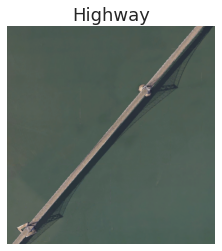

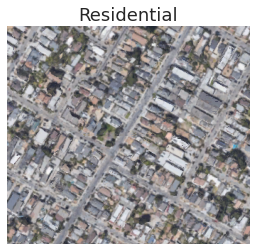

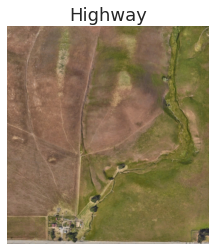

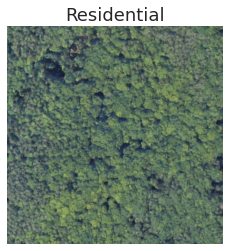

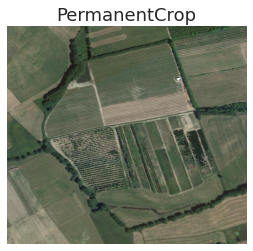

In [247]:
def predict(feature_extractor, model, images, device):
  resize_value = (224, 224)

  inference_data_transforms = Compose(
          [
              Resize(resize_value),
              ToTensor(),
              Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
          ]
      )
  
  encodings = [feature_extractor(image.convert("RGB"), return_tensors="pt").to(device) for image in images]

  predicted_class_idxs = []

  for i, encoding in enumerate(encodings):
    with torch.no_grad():
      outputs = model(**encoding)
      logits = outputs.logits

      predicted_class_idxs.append(logits.argmax(-1).item())
      predicted_class_name = model.config.id2label[predicted_class_idxs[i]]

      plt.imshow(images[i])
      plt.title(f"{predicted_class_name}")
      plt.axis("off")
      plt.show()


  return predicted_class_idxs


device = "cuda:0"
predicted_class_idxs = predict(feature_extractor, model, imgs, device)
wandb.log({"inference_images": 
           [wandb.Image(
               image,
               caption=f"Predicted class: {predicted_class_idxs[i]} {model.config.id2label[predicted_class_idxs[i]]}"
               ) for i, image in enumerate(imgs)]})

## 🔥 Attention heatmaps

The DINO model is used for visualizing attention maps.
Attention maps are overlayed on the input images.

In [262]:
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return image

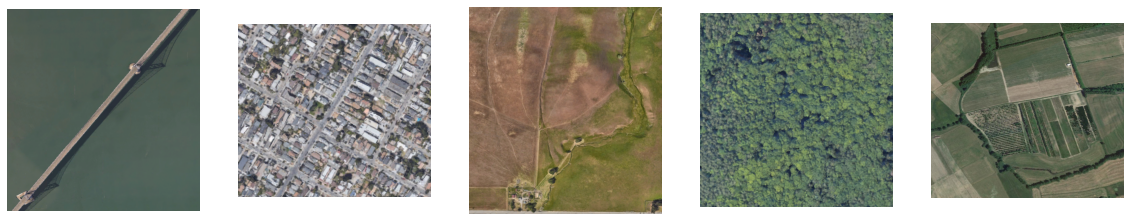

In [275]:
img_url = 'https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-finetuned-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110307.png'
image = load_image_from_url(img_url)

imgs_urls = [
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110307.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110454.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110708.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20114336.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20113158.png",
]
imgs = [load_image_from_url(img_url) for img_url in imgs_urls]

fig, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
for i, img in enumerate(imgs):
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

In [270]:
def preprocess_image(image, size=224):
    crop_layer = keras.layers.CenterCrop(224, 224)
    norm_layer = keras.layers.Normalization(
        mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
        variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
    )
    rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)
    image = np.array(image)
    image = tf.expand_dims(image, 0)
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")
    image = crop_layer(image)
    image = norm_layer(image)
    return image.numpy()

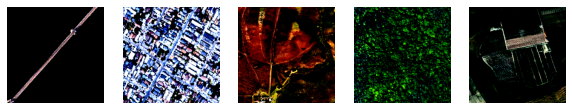

In [272]:
preprocessed_image = preprocess_image(image)
preprocessed_images = [preprocess_image(img) for img in imgs]

plt.figure(figsize=(10, 10))
for i, image in enumerate(preprocessed_images):
    ax = plt.subplot(1, len(preprocessed_images), i + 1)
    plt.imshow(image[0])
    plt.axis("off")

In [266]:
def get_gdrive_model(model_id: str) -> tf.keras.Model:
  model_path = gdown.download(id=model_id, quiet=False)
  with zipfile.ZipFile(model_path, "r") as zip_ref:
      zip_ref.extractall()
  model_name = model_path.split(".")[0]
  inputs = keras.Input((224, 224, 3))
  model = keras.models.load_model(model_name, compile=False)
  outputs, attention_weights = model(inputs)
  return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_model(id):
  loaded_model = get_gdrive_model(id)
  return loaded_model


vit_dino_base16 = get_model("16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN")

Downloading...
From: https://drive.google.com/uc?id=16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
To: /content/vit_dino_base16.zip
100%|██████████| 326M/326M [00:04<00:00, 71.1MB/s]


In [267]:
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

1/1 [==============================] - 3s 3s/step


In [286]:
predictions_attention_score_dict = {}

for i, image in enumerate(preprocessed_images):
    predictions, attention_score_dict = vit_dino_base16.predict(image)
    predictions_attention_score_dict[i] = attention_score_dict

1/1 [==============================] - 0s 122ms/step


In [268]:
def attention_heatmap(attention_score_dict, image, patch_size=16):
    num_tokens = 1
    num_heads = 12
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)
    w_featmap = image.shape[2] // patch_size
    h_featmap = image.shape[1] // patch_size
    attention_scores = attention_score_dict[attention_score_list[0]]
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))
    attentions = tf.image.resize(
        attentions, size=(h_featmap * patch_size, w_featmap * patch_size)
    )
    return attentions

In [305]:
def denormalize_image(image):
    in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
    in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = (image * in1k_std) + in1k_mean
    image = image / 255.0
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image

def plot_attention_heatmap(attention_score_dict, preprocessed_img_orig):
    image = denormalize_image(preprocessed_img_orig)
    attentions = attention_heatmap(attention_score_dict, image)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
    img_count = 0
    for i in range(3):
        for j in range(4):
            if img_count < len(attentions):
                axes[i, j].imshow(image[0])
                axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
                axes[i, j].title.set_text(f"Attention head: {img_count}")
                axes[i, j].axis("off")
                img_count += 1
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep="")
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    wandb.log({"attention_heatmap": [wandb.Image(data)]})
    wandb.log({"attention_heads attention maps": fig})
    return fig

<ipython-input-305-e75864826c54>:23: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



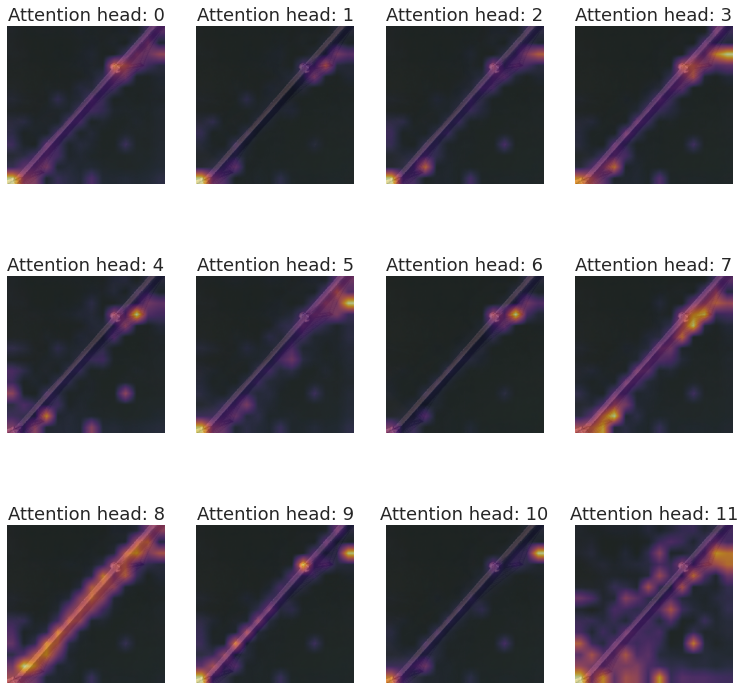

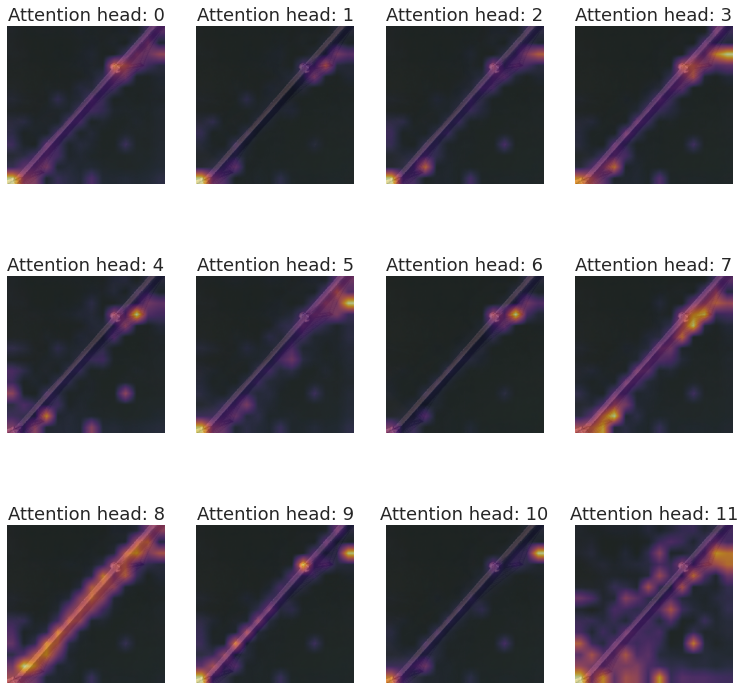

In [306]:
plot_attention_heatmap(predictions_attention_score_dict[0], preprocessed_images[0])

<ipython-input-305-e75864826c54>:23: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



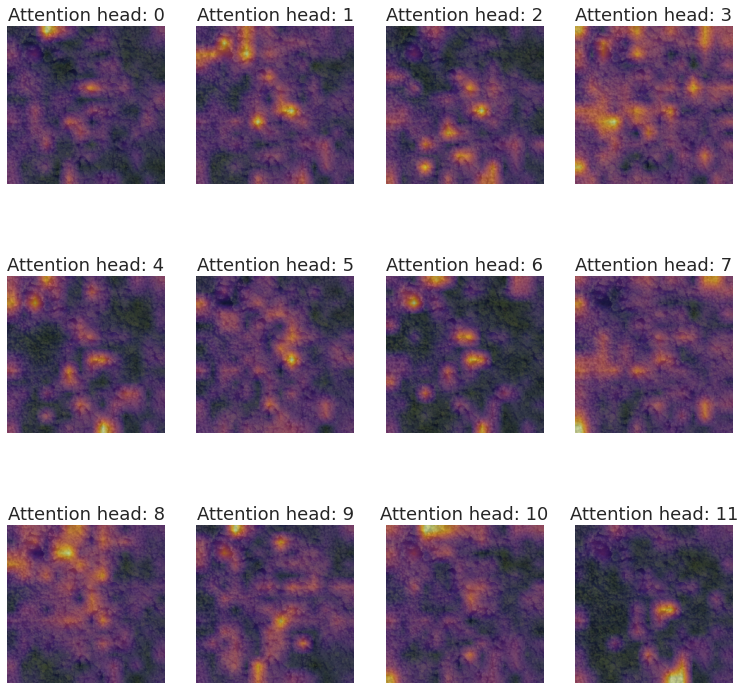

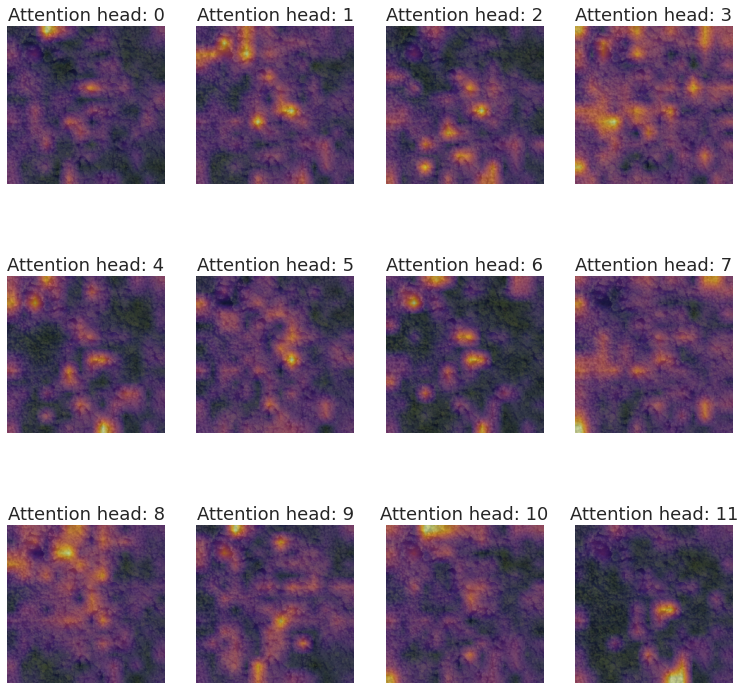

In [307]:
plot_attention_heatmap(predictions_attention_score_dict[3], preprocessed_images[3])

<ipython-input-305-e75864826c54>:23: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



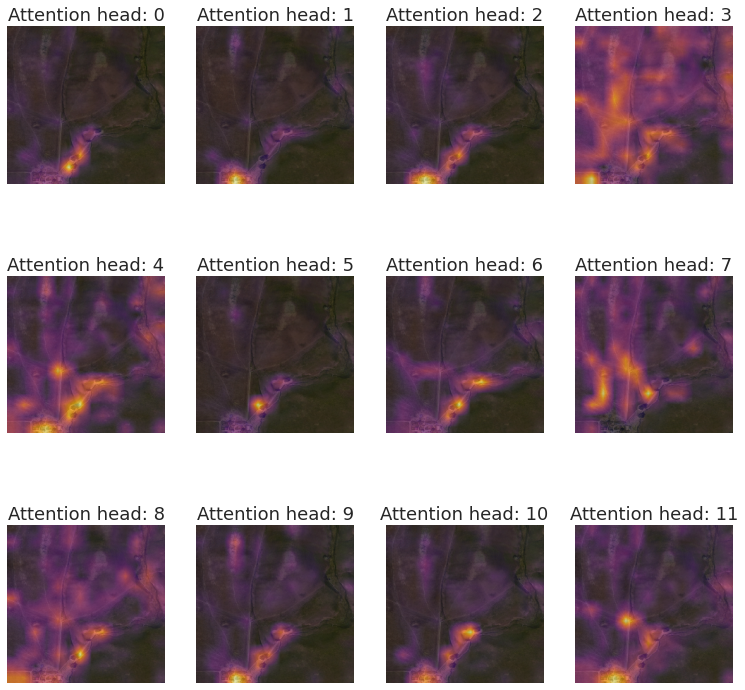

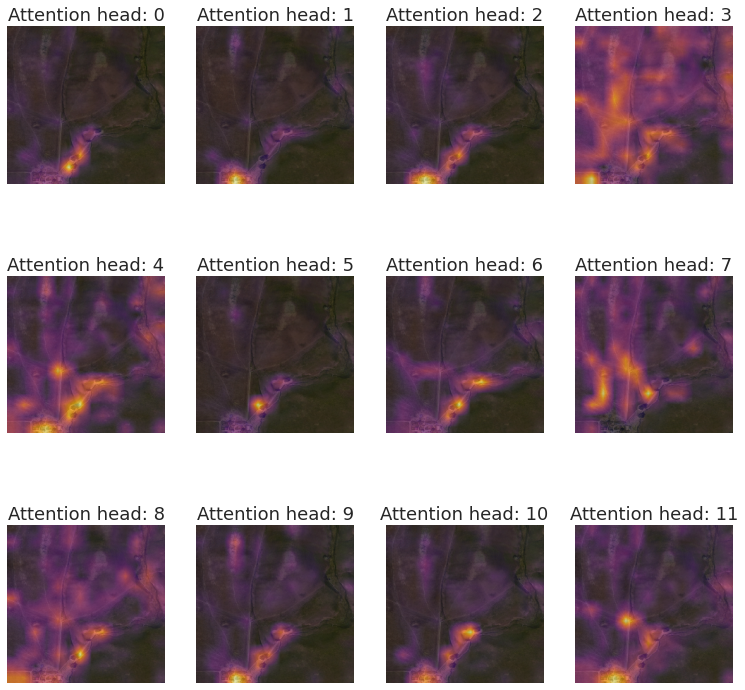

In [308]:
plot_attention_heatmap(predictions_attention_score_dict[2], preprocessed_images[2])

<ipython-input-305-e75864826c54>:23: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



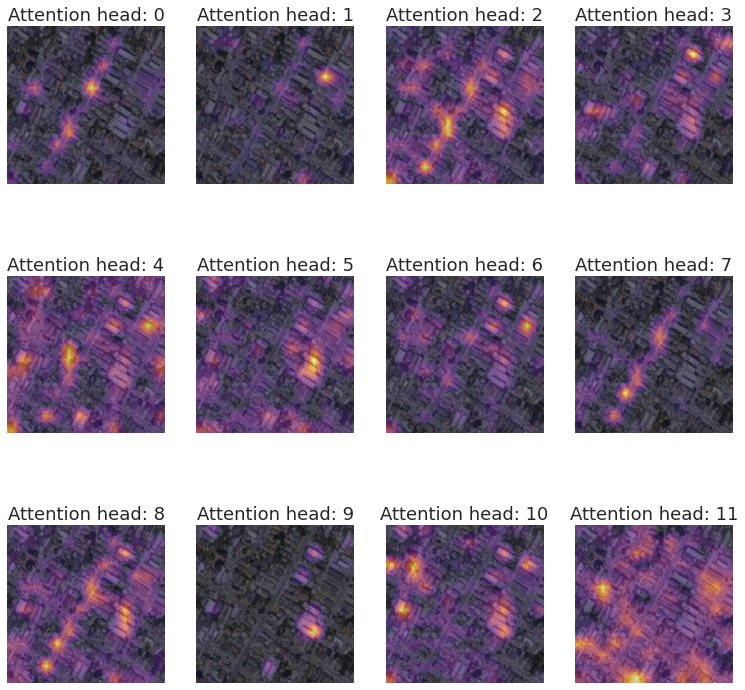

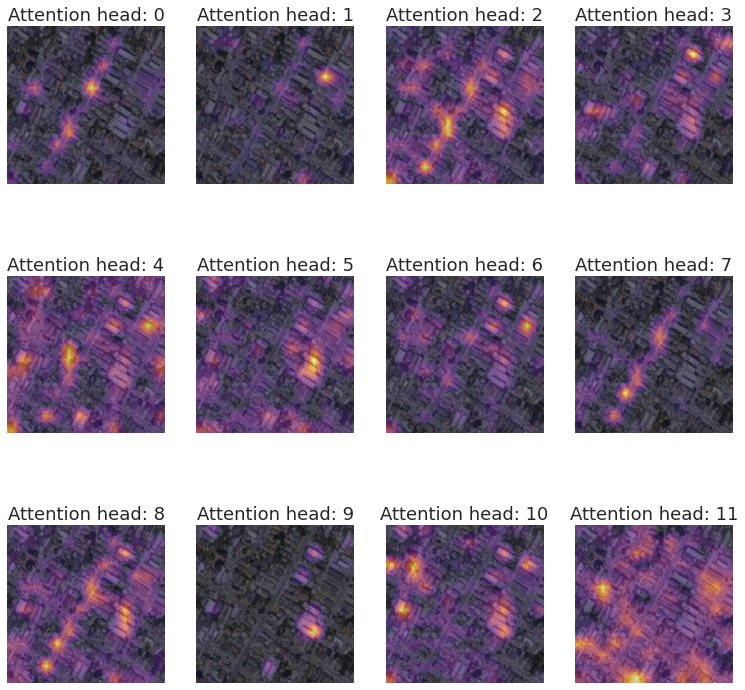

In [309]:
plot_attention_heatmap(predictions_attention_score_dict[1], preprocessed_images[1])

In [ ]:
test_dataset_maps = [img['image'] for img in test_dataset]
test_dataset_maps

In [ ]:
processed_images_testdataset = [preprocess_image(img) for img in test_dataset_maps]
for i, image in enumerate(processed_images_testdataset):
    predictions, attention_score_dict = vit_dino_base16.predict(image)
    plot_attention_heatmap(attention_score_dict, image)

1/1 [==============================] - 0s 92ms/step


<ipython-input-305-e75864826c54>:23: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



1/1 [==============================] - 0s 90ms/step


<ipython-input-305-e75864826c54>:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



1/1 [==============================] - 0s 429ms/step


## Inference using transformers pipeline

In [72]:
from transformers import pipeline


repo_name = "polejowska/vit-base-patch16-224-in21k-eurosat"
pipe = pipeline("image-classification", repo_name)

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--polejowska--vit-base-patch16-224-in21k-eurosat/snapshots/315a12f9981faa37e2c5ffa8347e53e1403b0496/config.json
Model config ViTConfig {
  "_name_or_path": "polejowska/vit-base-patch16-224-in21k-eurosat",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "AnnualCrop",
    "1": "Forest",
    "2": "HerbaceousVegetation",
    "3": "Highway",
    "4": "Industrial",
    "5": "Pasture",
    "6": "PermanentCrop",
    "7": "Residential",
    "8": "River",
    "9": "SeaLake"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture": 5,
    "PermanentCrop": 6,
    "Residential": 

Downloading:   0%|          | 0.00/343M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--polejowska--vit-base-patch16-224-in21k-eurosat/snapshots/315a12f9981faa37e2c5ffa8347e53e1403b0496/pytorch_model.bin
All model checkpoint weights were used when initializing ViTForImageClassification.

All the weights of ViTForImageClassification were initialized from the model checkpoint at polejowska/vit-base-patch16-224-in21k-eurosat.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ViTForImageClassification for predictions without further training.


Downloading:   0%|          | 0.00/325 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--polejowska--vit-base-patch16-224-in21k-eurosat/snapshots/315a12f9981faa37e2c5ffa8347e53e1403b0496/preprocessor_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--polejowska--vit-base-patch16-224-in21k-eurosat/snapshots/315a12f9981faa37e2c5ffa8347e53e1403b0496/config.json
Model config ViTConfig {
  "_name_or_path": "polejowska/vit-base-patch16-224-in21k-eurosat",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "AnnualCrop",
    "1": "Forest",
    "2": "HerbaceousVegetation",
    "3": "Highway",
    "4": "Industrial",
    "5": "Pasture",
    "6": "PermanentCrop",
    "7": "Residential",
    "8": "River",
    "9": "SeaLake"
  },
  "image_size": 224,
  "initializer_ra

In [73]:
pipe(imgs[0])

[{'score': 0.1587468683719635, 'label': 'Highway'},
 {'score': 0.1502288430929184, 'label': 'River'},
 {'score': 0.12287884205579758, 'label': 'AnnualCrop'},
 {'score': 0.11594471335411072, 'label': 'Pasture'},
 {'score': 0.11227864027023315, 'label': 'SeaLake'}]

In [ ]:
wandb.finish()

W&B report: https://wandb.ai/polejowska/vit-classification-eurosat/reports/Satellite-images-classification-using-Vision-Transformers--VmlldzozMTI0ODE2